In [1]:
!pip install wandb tensorboardX --quiet

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 124 kB 13.4 MB/s 
     |████████████████████████████████| 180 kB 12.8 MB/s 
     |████████████████████████████████| 140 kB 25.9 MB/s 
     |████████████████████████████████| 97 kB 2.0 MB/s 
     |████████████████████████████████| 63 kB 481 kB/s 


In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import wandb
import io
import os
from PIL import Image
from torch.utils.data import Dataset
from sklearn.manifold import TSNE
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA

In [5]:
WANDB_ON = True
SWEEP_ON = True
COUNT = None

In [6]:
class IMDB(Dataset):
    def __init__(self, URL: str = "https://www.imdb.com/chart/top-english-movies/", IMG_SIZE: tuple = (44,64)):
        self.URL = URL
        self.IMG_SIZE = IMG_SIZE
        self.transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        page = requests.get(URL)
        soup = BeautifulSoup(page.content, 'html.parser')
        movie_list = soup.find(class_='lister-list')
        movie_elems = movie_list.find_all('tr')
    
        movTitle = []
        movYear = []
        movRating = []
        movPoster = []

        for i, elm in enumerate(movie_elems):
            title = elm.find('td', 'titleColumn').a['title']
            movTitle.append(title)
            year = int(elm.find('td', 'titleColumn').span.string[1:-1])
            movYear.append(year)
            rating = float(elm.find('td', 'ratingColumn imdbRating').strong.string)
            movRating.append(rating)
            posterURL = elm.find('td', 'posterColumn').a.img['src']
            data = requests.get(posterURL).content
            img = Image.open(io.BytesIO(data)).resize(IMG_SIZE)
            array = np.array(img, dtype='uint8')
            movPoster.append(array)
            if i >= 150:
                break

        imdb = {'Movie Title':movTitle, 'Year Published':movYear, 'IMDb Rating':movRating, 'Movie Poster': movPoster}
        self.df = pd.DataFrame(imdb)


    def __len__(self):
        return self.df.shape[0]


    def __getitem__(self, index:int) -> np.ndarray:
        image = self.transform(self.df['Movie Poster'][index])
        return image
    
    def displayImage(self, index:int):
        image = self.df['Movie Poster'][index]
        plt.imshow(image)

In [7]:
if WANDB_ON:
    !wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [8]:
if WANDB_ON and SWEEP_ON:
    sweep_config = {
        "name": "MovieWeb",
        "method": "bayes",
        "metric": {
            "name": "test_loss",
            "goal": "minimize"
        },
        "parameters": {
            "learning_rate": {
                "distribution": "uniform",
                "min": 0.0001,
                "max": 0.01
            },
            "optimizer": {
                "values": ["Adam"]
            },
            "epochs":{
                "distribution": "normal",
                "mu": 1000,
                "sigma": 250,
            },
            "batch_size": {
                "distribution": "int_uniform",
                "min": 4,
                "max": 256
            },
            "random_seed": {
                "values": [42]
            },
            "validation_split": {
                "values": [.2]
            },
            "shuffle_dataset": {
                "values": [True]
            }
        }
    }

    sweep_id = wandb.sweep(sweep_config, project='MovieWeb', entity='cmerrill')

Create sweep with ID: pq5s7l4i
Sweep URL: https://wandb.ai/cmerrill/MovieWeb/sweeps/pq5s7l4i


In [9]:

#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.embedding_size = None
        
        #Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
            
        )
       
        #Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 2, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x) -> torch.Tensor:
        x = self.encoder(x)
        if x.size() != self.embedding_size:
            self.embedding_size = x.size()
        x = self.decoder(x)
        return x

    def embedding(self, x) -> torch.Tensor:
        x = torch.flatten(self.encoder(x), start_dim=1).T
        return x

    def count_parameters(self) -> int:
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [10]:
def compression_ratio():
    temp_db = IMDB()
    x = temp_db.__getitem__(0)
    model = ConvAutoencoder()
    x = torch.reshape(x, (1,*x.shape))
    _ = model.forward(x)
    cr = np.prod(x.shape) / np.prod(model.embedding_size)
    return cr



#print(f'Compression ratio: {compression_ratio()}:1')

In [11]:
hasGPU = torch.cuda.is_available

In [12]:
def train():
    # get_device()
    with wandb.init(project='MovieWeb', entity='cmerrill') if WANDB_ON else None as run:
        config = {}
        config['learning_rate'] = 0.1
        config['batch_size'] = 4
        config['epochs'] = 2000
        config['validation_split'] = 0.2
        config['shuffle_dataset'] = True
        config['random_seed'] = 42
        config['optimizer'] = "SGD"
        
        if WANDB_ON:
            config.update(wandb.config)
        
        config['epochs'] = int(config['epochs'])
        print(config)
        
        # Creating data indices for training and validation splits:
        imdbDataset = IMDB()
        dataset_size = len(imdbDataset)
        indices = list(range(dataset_size))
        split = int(np.floor(config['validation_split'] * dataset_size))
        if config['shuffle_dataset'] :
            np.random.seed(config['random_seed'])
            np.random.shuffle(indices)
        train_indices, test_indices = indices[split:], indices[:split]

        # Creating PT data samplers and loaders:
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SubsetRandomSampler(test_indices)

        train_loader = torch.utils.data.DataLoader(
            imdbDataset, 
            batch_size=config['batch_size'], 
            sampler=train_sampler
        )

        test_loader = torch.utils.data.DataLoader(
            imdbDataset, 
            batch_size=config['batch_size'],
            sampler=test_sampler
        )

        #Instantiate the model
        model = ConvAutoencoder()
        if hasGPU():
          model.cuda()
        else:
          model.cpu()

        if WANDB_ON:
            wandb.watch(model)

        #Loss function
        criterion = nn.MSELoss()

        #Optimizer
        optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), lr = config['learning_rate'])

        for epoch in range(1, config['epochs']+1):
            # monitor training loss
            train_loss = 0.0
            
            # Training
            for images in train_loader:
              if hasGPU():
                images = images.cuda()
              else:
                images = images.cpu()
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, images)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()*images.size(0)
                
            train_loss = train_loss/len(train_loader)
            
            if WANDB_ON:
                wandb.log({"loss": train_loss})

            #monitor testing loss
            test_loss = 0.0

            # Testing
            for images in test_loader:
              if hasGPU():
                images = images.cuda()
              else:
                images = images.cpu()
              outputs = model(images)
              loss = criterion(outputs, images)
              test_loss += loss.item()*images.size(0)
          
            test_loss = test_loss/len(test_loader)
            
            if WANDB_ON:
                wandb.log({"test_loss": test_loss})

            print('Epoch {} | Train Loss: {:.4f} |  Test Loss: {:.4f}'.format(epoch, train_loss, test_loss))

        #Batch of test images
        dataiter = iter(train_loader)
        images = dataiter.next()
        if hasGPU():
          images = images.cuda()
        else:
          images = images.cpu()

        #Sample outputs
        outputs = model(images)
        images = images.cpu().data.numpy()
        outputs = outputs.cpu().data.numpy()

        #Original Images
        f, axarr = plt.subplots(1,4,figsize=(12,12))
        for idx in np.arange(4):
            axarr[idx].imshow(np.moveaxis(images[idx], 0, -1))
            axarr[idx].tick_params(
                left=False, 
                right=False , 
                labelleft=False ,
                labelbottom=False, 
                bottom=False
            )
        if WANDB_ON:
            wandb.log({"true_images": plt})
        else:
            plt.show()

        #Reconstructed Images
        f, axarr = plt.subplots(1,4,figsize=(12,12))
        for idx in np.arange(4):
            axarr[idx].imshow(np.moveaxis(outputs[idx], 0, -1))
            axarr[idx].tick_params(
                left=False, 
                right=False , 
                labelleft=False ,
                labelbottom=False, 
                bottom=False
            )

        if WANDB_ON:
            wandb.log({"reconstructed_images": plt})
        else:
            plt.show()

        if WANDB_ON:
            # Save your model.
            torch.save(model.state_dict(), './saved_models/model.pth')
            # Save as artifact for version control.
            artifact = wandb.Artifact(f'model', type='model')
            artifact.add_file('./saved_models/model.pth')
            run.log_artifact(artifact, aliases=['latest', run.name])
            run.join()
            # Delete the file from the saved_models folder.
            os.remove('./saved_models/model.pth')
            run.finish()

wandb: Agent Starting Run: 7u9489eh with config:
wandb: 	batch_size: 249
wandb: 	epochs: 884.8249060823005
wandb: 	learning_rate: 0.006177312115279287
wandb: 	optimizer: Adam
wandb: 	random_seed: 42
wandb: 	shuffle_dataset: True
wandb: 	validation_split: 0.2
wandb: Currently logged in as: cmerrill (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


{'learning_rate': 0.006177312115279287, 'batch_size': 249, 'epochs': 884, 'validation_split': 0.2, 'shuffle_dataset': True, 'random_seed': 42, 'optimizer': 'Adam'}
Epoch 1 | Train Loss: 0.0000 |  Test Loss: 3.5289
Epoch 2 | Train Loss: 0.0000 |  Test Loss: 3.5289
Epoch 3 | Train Loss: 0.0000 |  Test Loss: 3.5289
Epoch 4 | Train Loss: 0.0000 |  Test Loss: 3.5289
Epoch 5 | Train Loss: 0.0000 |  Test Loss: 3.5289
Epoch 6 | Train Loss: 0.0000 |  Test Loss: 3.5289
Epoch 7 | Train Loss: 0.0000 |  Test Loss: 3.5289
Epoch 8 | Train Loss: 0.0000 |  Test Loss: 3.5289
Epoch 9 | Train Loss: 0.0000 |  Test Loss: 3.5289
Epoch 10 | Train Loss: 0.0000 |  Test Loss: 3.5289
Epoch 11 | Train Loss: 0.0000 |  Test Loss: 3.5289
Epoch 12 | Train Loss: 0.0000 |  Test Loss: 3.5289
Epoch 13 | Train Loss: 0.0000 |  Test Loss: 3.5289
Epoch 14 | Train Loss: 0.0000 |  Test Loss: 3.5289
Epoch 15 | Train Loss: 0.0000 |  Test Loss: 3.5289
Epoch 16 | Train Loss: 0.0000 |  Test Loss: 3.5289
Epoch 17 | Train Loss: 0.0000

loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,████████████████████████▁▁█████▁████████
loss,0.0
test_loss,3.52888


Run 7u9489eh errored: FileNotFoundError(2, 'No such file or directory')
wandb: ERROR Run 7u9489eh errored: FileNotFoundError(2, 'No such file or directory')
wandb: Agent Starting Run: t163yt4w with config:
wandb: 	batch_size: 152
wandb: 	epochs: 1100.7308371227027
wandb: 	learning_rate: 0.009868083321254334
wandb: 	optimizer: Adam
wandb: 	random_seed: 42
wandb: 	shuffle_dataset: True
wandb: 	validation_split: 0.2
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


{'learning_rate': 0.009868083321254334, 'batch_size': 152, 'epochs': 1100, 'validation_split': 0.2, 'shuffle_dataset': True, 'random_seed': 42, 'optimizer': 'Adam'}
Epoch 1 | Train Loss: 0.0000 |  Test Loss: 3.6475
Epoch 2 | Train Loss: 0.0000 |  Test Loss: 3.6475
Epoch 3 | Train Loss: 0.0000 |  Test Loss: 3.6475
Epoch 4 | Train Loss: 0.0000 |  Test Loss: 3.6475
Epoch 5 | Train Loss: 0.0000 |  Test Loss: 3.6475
Epoch 6 | Train Loss: 0.0000 |  Test Loss: 3.6475
Epoch 7 | Train Loss: 0.0000 |  Test Loss: 3.6475
Epoch 8 | Train Loss: 0.0000 |  Test Loss: 3.6475
Epoch 9 | Train Loss: 0.0000 |  Test Loss: 3.6475
Epoch 10 | Train Loss: 0.0000 |  Test Loss: 3.6475
Epoch 11 | Train Loss: 0.0000 |  Test Loss: 3.6475
Epoch 12 | Train Loss: 0.0000 |  Test Loss: 3.6475
Epoch 13 | Train Loss: 0.0000 |  Test Loss: 3.6475
Epoch 14 | Train Loss: 0.0000 |  Test Loss: 3.6475
Epoch 15 | Train Loss: 0.0000 |  Test Loss: 3.6475
Epoch 16 | Train Loss: 0.0000 |  Test Loss: 3.6475
Epoch 17 | Train Loss: 0.000

loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▁█▁▅▅▅▅▅▅█▅▁▅██▁▅▅▁▁▅▁▅▅▅▁▁▅▅█▅▅█▁▅▁▁▅▅▁
loss,0.0
test_loss,3.64754


Run t163yt4w errored: FileNotFoundError(2, 'No such file or directory')
wandb: ERROR Run t163yt4w errored: FileNotFoundError(2, 'No such file or directory')
wandb: Agent Starting Run: azj52gj0 with config:
wandb: 	batch_size: 10
wandb: 	epochs: 931.2001459376196
wandb: 	learning_rate: 0.004344732857906708
wandb: 	optimizer: Adam
wandb: 	random_seed: 42
wandb: 	shuffle_dataset: True
wandb: 	validation_split: 0.2
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


{'learning_rate': 0.004344732857906708, 'batch_size': 10, 'epochs': 931, 'validation_split': 0.2, 'shuffle_dataset': True, 'random_seed': 42, 'optimizer': 'Adam'}
Epoch 1 | Train Loss: 0.0000 |  Test Loss: 1.2678
Epoch 2 | Train Loss: 0.0000 |  Test Loss: 1.2678
Epoch 3 | Train Loss: 0.0000 |  Test Loss: 1.2678
Epoch 4 | Train Loss: 0.0000 |  Test Loss: 1.2678
Epoch 5 | Train Loss: 0.0000 |  Test Loss: 1.2678
Epoch 6 | Train Loss: 0.0000 |  Test Loss: 1.2678
Epoch 7 | Train Loss: 0.0000 |  Test Loss: 1.2678
Epoch 8 | Train Loss: 0.0000 |  Test Loss: 1.2678
Epoch 9 | Train Loss: 0.0000 |  Test Loss: 1.2678
Epoch 10 | Train Loss: 0.0000 |  Test Loss: 1.2678
Epoch 11 | Train Loss: 0.0000 |  Test Loss: 1.2678
Epoch 12 | Train Loss: 0.0000 |  Test Loss: 1.2678
Epoch 13 | Train Loss: 0.0000 |  Test Loss: 1.2678
Epoch 14 | Train Loss: 0.0000 |  Test Loss: 1.2678
Epoch 15 | Train Loss: 0.0000 |  Test Loss: 1.2678
Epoch 16 | Train Loss: 0.0000 |  Test Loss: 1.2678
Epoch 17 | Train Loss: 0.0000 

loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▅▅▅▅▅▅▅▅▅▅▅▅▁█▁▅█▁▅▅▅▅▁▅▁▅▅▅█▅▅▅▅▅▅▅▅█▅▅
loss,0.0
test_loss,1.26777


Run azj52gj0 errored: FileNotFoundError(2, 'No such file or directory')
wandb: ERROR Run azj52gj0 errored: FileNotFoundError(2, 'No such file or directory')
wandb: Agent Starting Run: srhnog4e with config:
wandb: 	batch_size: 75
wandb: 	epochs: 1336.949089916868
wandb: 	learning_rate: 0.003802847322686195
wandb: 	optimizer: Adam
wandb: 	random_seed: 42
wandb: 	shuffle_dataset: True
wandb: 	validation_split: 0.2
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


{'learning_rate': 0.003802847322686195, 'batch_size': 75, 'epochs': 1336, 'validation_split': 0.2, 'shuffle_dataset': True, 'random_seed': 42, 'optimizer': 'Adam'}
Epoch 1 | Train Loss: 0.0000 |  Test Loss: 3.7252
Epoch 2 | Train Loss: 0.0000 |  Test Loss: 3.7252
Epoch 3 | Train Loss: 0.0000 |  Test Loss: 3.7252
Epoch 4 | Train Loss: 0.0000 |  Test Loss: 3.7252
Epoch 5 | Train Loss: 0.0000 |  Test Loss: 3.7252
Epoch 6 | Train Loss: 0.0000 |  Test Loss: 3.7252
Epoch 7 | Train Loss: 0.0000 |  Test Loss: 3.7252
Epoch 8 | Train Loss: 0.0000 |  Test Loss: 3.7252
Epoch 9 | Train Loss: 0.0000 |  Test Loss: 3.7252
Epoch 10 | Train Loss: 0.0000 |  Test Loss: 3.7252
Epoch 11 | Train Loss: 0.0000 |  Test Loss: 3.7252
Epoch 12 | Train Loss: 0.0000 |  Test Loss: 3.7252
Epoch 13 | Train Loss: 0.0000 |  Test Loss: 3.7252
Epoch 14 | Train Loss: 0.0000 |  Test Loss: 3.7252
Epoch 15 | Train Loss: 0.0000 |  Test Loss: 3.7252
Epoch 16 | Train Loss: 0.0000 |  Test Loss: 3.7252
Epoch 17 | Train Loss: 0.0000

loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▁▅█▅▅▁▁▅▅▅▅▅▅▅▁█▅▁▅▅▅▅▁▅▅▅▁▅▅█▅▁▅▅▅▁▅▅▅▅
loss,0.0
test_loss,3.72522


Run srhnog4e errored: FileNotFoundError(2, 'No such file or directory')
wandb: ERROR Run srhnog4e errored: FileNotFoundError(2, 'No such file or directory')
wandb: Agent Starting Run: gih4y7x1 with config:
wandb: 	batch_size: 26
wandb: 	epochs: 691.9854274283125
wandb: 	learning_rate: 0.007819479105048276
wandb: 	optimizer: Adam
wandb: 	random_seed: 42
wandb: 	shuffle_dataset: True
wandb: 	validation_split: 0.2
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


{'learning_rate': 0.007819479105048276, 'batch_size': 26, 'epochs': 691, 'validation_split': 0.2, 'shuffle_dataset': True, 'random_seed': 42, 'optimizer': 'Adam'}
Epoch 1 | Train Loss: 0.0000 |  Test Loss: 1.7909
Epoch 2 | Train Loss: 0.0000 |  Test Loss: 1.7909
Epoch 3 | Train Loss: 0.0000 |  Test Loss: 1.7909
Epoch 4 | Train Loss: 0.0000 |  Test Loss: 1.7909
Epoch 5 | Train Loss: 0.0000 |  Test Loss: 1.7909
Epoch 6 | Train Loss: 0.0000 |  Test Loss: 1.7909
Epoch 7 | Train Loss: 0.0000 |  Test Loss: 1.7909
Epoch 8 | Train Loss: 0.0000 |  Test Loss: 1.7909
Epoch 9 | Train Loss: 0.0000 |  Test Loss: 1.7909
Epoch 10 | Train Loss: 0.0000 |  Test Loss: 1.7909
Epoch 11 | Train Loss: 0.0000 |  Test Loss: 1.7909
Epoch 12 | Train Loss: 0.0000 |  Test Loss: 1.7909
Epoch 13 | Train Loss: 0.0000 |  Test Loss: 1.7909
Epoch 14 | Train Loss: 0.0000 |  Test Loss: 1.7909
Epoch 15 | Train Loss: 0.0000 |  Test Loss: 1.7909
Epoch 16 | Train Loss: 0.0000 |  Test Loss: 1.7909
Epoch 17 | Train Loss: 0.0000 

loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▃▃▆▆▃▃▁▃▆▆▆▆▃▃▆▆▆▆▃▆▃█▆▆▆▆▆▆▃▃▃█▆▃▃▃▆▃▆▆
loss,0.0
test_loss,1.79086


Run gih4y7x1 errored: FileNotFoundError(2, 'No such file or directory')
wandb: ERROR Run gih4y7x1 errored: FileNotFoundError(2, 'No such file or directory')
wandb: Agent Starting Run: 2s58oyl6 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 1335.6647308663148
wandb: 	learning_rate: 0.002324667348920517
wandb: 	optimizer: Adam
wandb: 	random_seed: 42
wandb: 	shuffle_dataset: True
wandb: 	validation_split: 0.2
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


{'learning_rate': 0.002324667348920517, 'batch_size': 16, 'epochs': 1335, 'validation_split': 0.2, 'shuffle_dataset': True, 'random_seed': 42, 'optimizer': 'Adam'}
Epoch 1 | Train Loss: 0.0000 |  Test Loss: 1.9194
Epoch 2 | Train Loss: 0.0000 |  Test Loss: 1.9194
Epoch 3 | Train Loss: 0.0000 |  Test Loss: 1.9194
Epoch 4 | Train Loss: 0.0000 |  Test Loss: 1.9194
Epoch 5 | Train Loss: 0.0000 |  Test Loss: 1.9194
Epoch 6 | Train Loss: 0.0000 |  Test Loss: 1.9194
Epoch 7 | Train Loss: 0.0000 |  Test Loss: 1.9194
Epoch 8 | Train Loss: 0.0000 |  Test Loss: 1.9194
Epoch 9 | Train Loss: 0.0000 |  Test Loss: 1.9194
Epoch 10 | Train Loss: 0.0000 |  Test Loss: 1.9194
Epoch 11 | Train Loss: 0.0000 |  Test Loss: 1.9194
Epoch 12 | Train Loss: 0.0000 |  Test Loss: 1.9194
Epoch 13 | Train Loss: 0.0000 |  Test Loss: 1.9194
Epoch 14 | Train Loss: 0.0000 |  Test Loss: 1.9194
Epoch 15 | Train Loss: 0.0000 |  Test Loss: 1.9194
Epoch 16 | Train Loss: 0.0000 |  Test Loss: 1.9194
Epoch 17 | Train Loss: 0.0000

loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▁▅▅▅▅▅█▅▅▅█▅▅█▅▅▅██▅█▅▅▁▅▅█▅▅▁▅▅▅▅▅█▅█▅▅
loss,0.0
test_loss,1.91939


Run 2s58oyl6 errored: FileNotFoundError(2, 'No such file or directory')
wandb: ERROR Run 2s58oyl6 errored: FileNotFoundError(2, 'No such file or directory')
Detected 5 failed runs in a row at start, killing sweep.
wandb: ERROR Detected 5 failed runs in a row at start, killing sweep.
wandb: To change this value set WANDB_AGENT_MAX_INITIAL_FAILURES=val


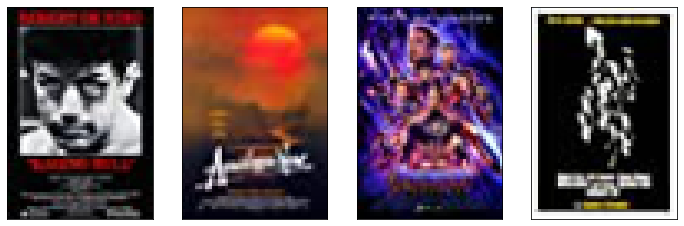

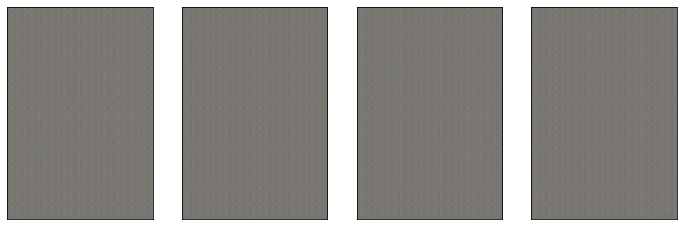

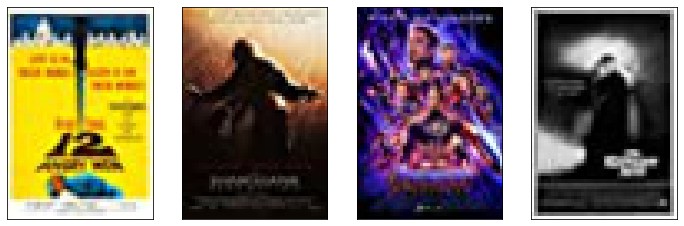

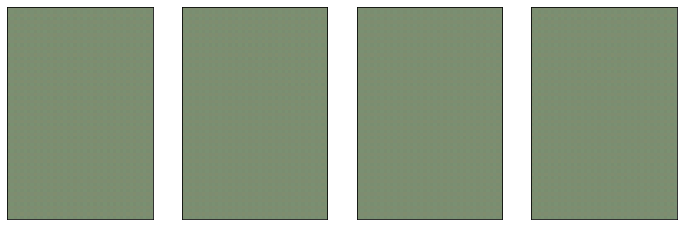

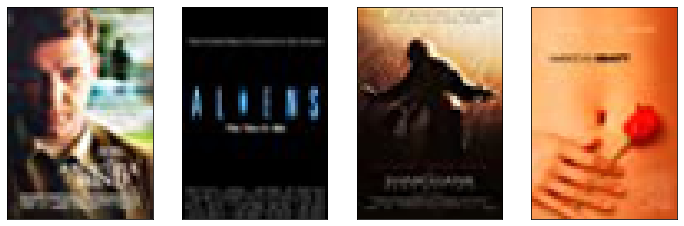

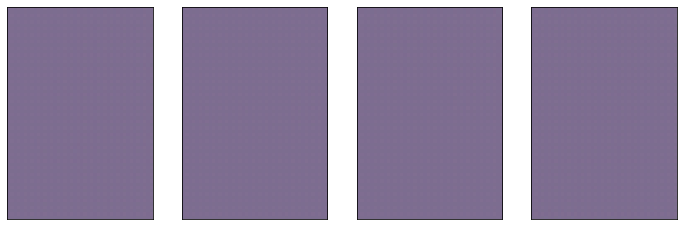

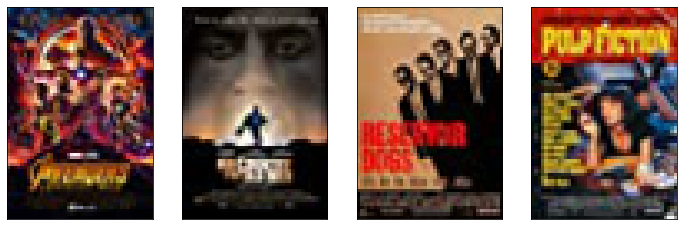

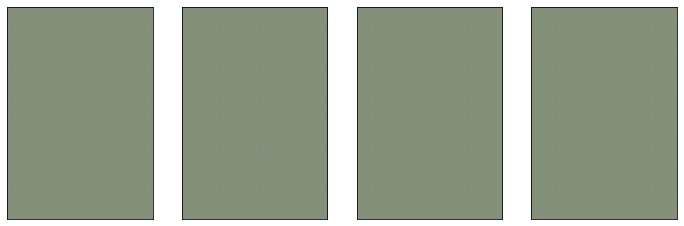

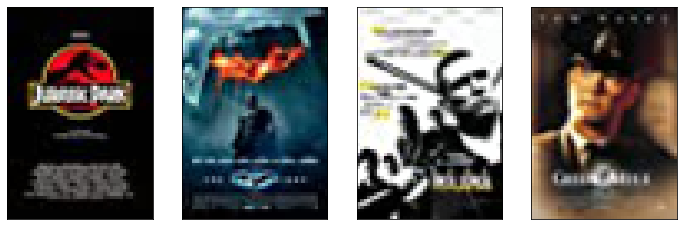

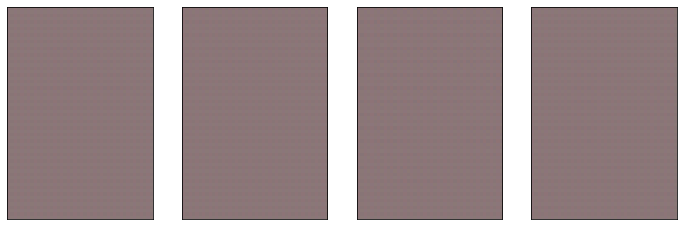

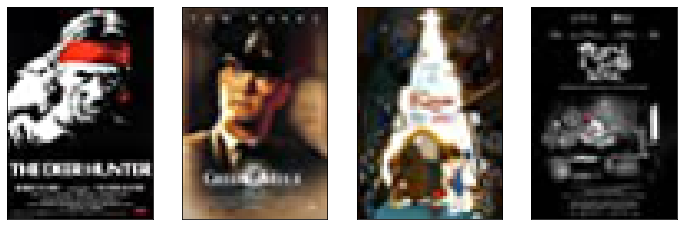

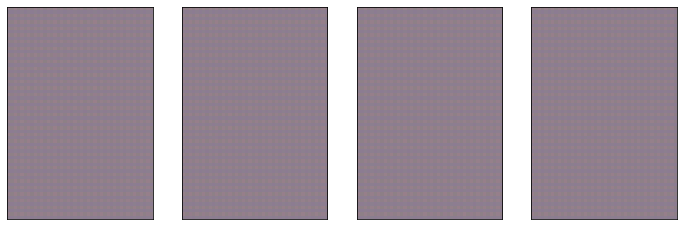

In [13]:
if WANDB_ON:
    if SWEEP_ON:
        wandb.agent(sweep_id, function=train, count=COUNT)
    else:
        train()

- Run all of the data through the model to get the embedding for each poster

In [14]:
def getBestModel(sweep_id):
    api = wandb.Api()

    sweep = api.sweep(f"cmerrill/MovieWeb/{sweep_id}")
    runs = sorted(sweep.runs,
        key=lambda run: run.summary.get("test_loss", 0))
    runs = list(filter(lambda run: run.summary.get("test_loss") not in [0,None],runs))
    test_loss = runs[0].summary.get("name", 0)
    print(f"Best run {runs[0].name} with {test_loss} test loss")

    run = wandb.init()
    artifact = run.use_artifact(f'cmerrill/MovieWeb/model:{runs[0].name}', type='model')
    artifact_dir = artifact.download()
    model = ConvAutoencoder()
    checkpoint = torch.load(os.path.join(artifact_dir, 'model.pth'))
    model.load_state_dict(checkpoint)
    
    return model

In [15]:
model = getBestModel('wd6dnfqw')

Best run absurd-sweep-55 with 0 test loss


In [16]:
def validateBestModel(model):
    
    imdbDataset = IMDB()
    # Creating data indices for training and validation splits:
    dataset_size = len(imdbDataset)
    indices = list(range(dataset_size))
    split = int(np.floor(.2 * dataset_size))
    np.random.seed(42)
    np.random.shuffle(indices)
    test_indices = indices[:split]

    # Creating PyTorch data samplers and loaders:
    test_sampler = SubsetRandomSampler(test_indices)

    test_loader = torch.utils.data.DataLoader(
        imdbDataset, 
        batch_size=8,
        sampler=test_sampler
    )

    #Batch of test images
    dataiter = iter(test_loader)
    images = dataiter.next()
    # images = images.cuda()

    #Sample outputs
    outputs = model(images)
    images = images.cpu().data.numpy()
    outputs = outputs.cpu().data.numpy()

    #Original Images
    print("Test Images")
    f, axarr = plt.subplots(1,8,figsize=(12,12))
    for idx in np.arange(8):
        axarr[idx].imshow(np.moveaxis(images[idx], 0, -1))
        axarr[idx].tick_params(
            left=False, 
            right=False , 
            labelleft=False ,
            labelbottom=False, 
            bottom=False
        )
    plt.show()

    #Reconstructed Images
    print('Reconstructed Images')
    f, axarr = plt.subplots(1,8,figsize=(12,12))
    for idx in np.arange(8):
        axarr[idx].imshow(np.moveaxis(outputs[idx], 0, -1))
        axarr[idx].tick_params(
            left=False, 
            right=False , 
            labelleft=False ,
            labelbottom=False, 
            bottom=False
        )
    plt.show()

Test Images


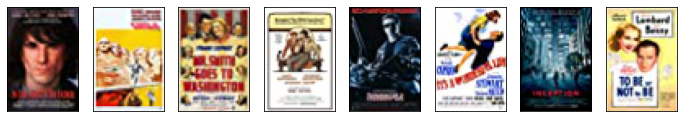

Reconstructed Images


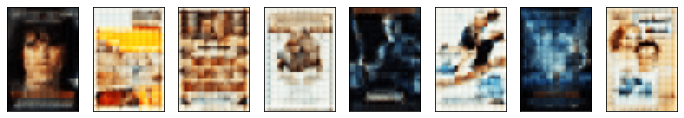

In [17]:
validateBestModel(model)

In [18]:
imdbDataset = IMDB()

data_loader = torch.utils.data.DataLoader(
    imdbDataset, 
    batch_size=len(imdbDataset),
)

#Batch of test images
dataiter = iter(data_loader)
outputs = model.embedding(next(dataiter))
outputs = outputs.T.cpu().data.numpy()

X_embedded = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(outputs)

In [22]:
x, y, z = zip(*X_embedded)
fig = px.scatter_3d(x=x, y=y, z=z)
fig.show()